training & result

In [1]:
from fastkaggle import *
import os
import timm
from fastai.vision.all import *
import gc
import os
from matplotlib import pyplot as plt
import cv2
set_seed(42)

In [2]:
comp = 'data'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

In [3]:
path

Path('data')

In [4]:
path.ls()

(#2) [Path('data/test'),Path('data/train')]

In [3]:
trn_path = path/'train'
files = get_image_files(trn_path)

print(trn_path)

data\train


In [6]:
models = {
    'convnext_tiny_in22k': {
        (Resize(480, method='squish'), 224),
    },
}


In [7]:
def find_lr(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=[error_rate], cbs=cbs).to_fp16()
    lr_valley, lr_slide = learn.lr_find(suggest_funcs=(valley, slide))
    
    return lr_valley, lr_slide


--- convnext_tiny_in22k
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


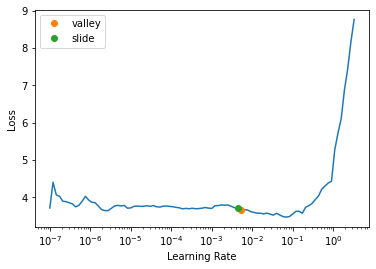

In [8]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        lr_valley, lr_slide = find_lr(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()

In [9]:
def plot_values(recorder, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(recorder.values))), recorder.values[skip_start:], label='train')
        if with_valid:
            idx = (np.array(recorder.iters)<skip_start).sum()
            valid_col = recorder.metric_names.index('valid_accuracy') - 1 
            plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(valid_col), label='valid')
            plt.figure(1)
            plt.legend()

In [10]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
                                       batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)

    cbs = [GradientAccumulation(64) if accum else [], EarlyStoppingCallback(min_delta=1e-4, patience=10), SaveModelCallback(monitor="valid_loss")]
    learn = vision_learner(dls, arch, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()
    learn.recorder.train_metrics = True
    tst_files = get_image_files(path/'test').sorted()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()
        learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()

    return learn, dls


In [11]:
torch.cuda.empty_cache()

--- convnext_tiny_in22k
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.133938,0.573618,0.426382,0.700569,0.752404,0.247596,09:07


Better model found at epoch 0 with valid_loss value: 0.7005690336227417.


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,0.597284,0.764874,0.235126,0.341180,0.893630,0.106370,11:20
1,0.472353,0.832182,0.167819,0.259328,0.923678,0.076322,11:20
2,0.375200,0.876803,0.123197,0.213536,0.937500,0.062500,11:20
3,0.336717,0.885817,0.114183,0.208195,0.938101,0.061899,11:21
4,0.320921,0.898588,0.101412,0.180140,0.947115,0.052885,11:22
5,0.279587,0.904147,0.095853,0.200307,0.947716,0.052284,11:21
6,0.252745,0.910757,0.089243,0.190974,0.945312,0.054688,11:24
7,0.257837,0.920823,0.079177,0.184023,0.948918,0.051082,11:25
8,0.264751,0.923678,0.076322,0.169028,0.949519,0.050481,11:24
9,0.204797,0.922927,0.077073,0.168030,0.950721,0.049279,11:24


Better model found at epoch 0 with valid_loss value: 0.34118005633354187.
Better model found at epoch 1 with valid_loss value: 0.2593284547328949.
Better model found at epoch 2 with valid_loss value: 0.21353599429130554.
Better model found at epoch 3 with valid_loss value: 0.20819464325904846.
Better model found at epoch 4 with valid_loss value: 0.18014028668403625.
Better model found at epoch 8 with valid_loss value: 0.16902831196784973.
Better model found at epoch 9 with valid_loss value: 0.16802978515625.
Better model found at epoch 10 with valid_loss value: 0.14995047450065613.
Better model found at epoch 11 with valid_loss value: 0.14935845136642456.
Better model found at epoch 15 with valid_loss value: 0.1371968537569046.
Better model found at epoch 20 with valid_loss value: 0.12145090848207474.
Better model found at epoch 22 with valid_loss value: 0.11633226275444031.
Better model found at epoch 25 with valid_loss value: 0.11072362959384918.
Better model found at epoch 27 with v

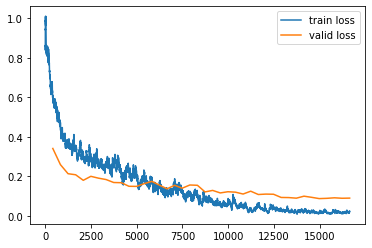

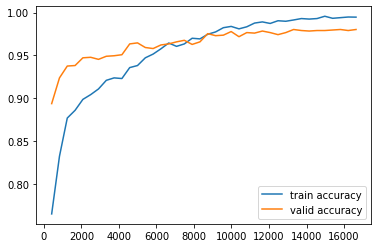

In [12]:
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=4, epochs=40)
        learn.save(arch)
        learn.export("models/"+arch+".pkl")

        
        gc.collect()
        torch.cuda.empty_cache()

In [7]:
models = {
    'convnext_tiny_in22k': {
        (Resize(480, method='squish'), 224),
    },
}

def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()

    return learn, dls

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()


--- convnext_tiny_in22k
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [8]:
from fastai.text.all import * 
learner= learn.load("convnext_tiny_in22k")

In [7]:
interpret = ClassificationInterpretation.from_learner(learner)

In [ ]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.94      0.97      0.96        66
   bacterial_leaf_streak       0.98      0.98      0.98        59
bacterial_panicle_blight       1.00      1.00      1.00        48
                   blast       0.98      0.99      0.99       312
              brown_spot       0.97      0.99      0.98       153
              dead_heart       1.00      1.00      1.00       218
            downy_mildew       0.97      0.96      0.97       101
                   hispa       0.96      0.96      0.96       233
                  normal       0.98      0.97      0.97       286
                  tungro       0.99      0.97      0.98       188

                accuracy                           0.98      1664
               macro avg       0.98      0.98      0.98      1664
            weighted avg       0.98      0.98      0.98      1664



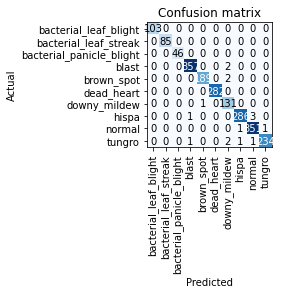

In [8]:
interpret.plot_confusion_matrix()

In [9]:
for arch,details in models.items():
    for item,size in details:        
        dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
                batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//4)
        tst_files = get_image_files(path/'test').sorted()
        tst_dl = dls.test_dl(tst_files, with_labels=True, num_workers=0)
        tst_dl

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [10]:
acc = accuracy(*learner.get_preds(dl=tst_dl))
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9049903750419617 %.


In [24]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']